In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
len(words)

32033

In [20]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Boilerplate MLP

In [6]:
# Build Dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Changes and Notes
* `b2 * 0`  and `W2 * 0.1` since we want the logits closer to 0, so we remove the bias and scale down W2
* You can get dead neurons in activation functions. This can be from bad luck, but even if they don't die, you can saturate the activation and significantly slow down learning.
    * If you see this oversaturation, this will be beacuse values that are too extreme are being fed into the activation
    * In our case we can scale down `b1 * 0.01` and `W1 * 0.2`
* In deeper networks (i.e 50), a bad initialization can stop a network from learning entirely
* Initialization used to be a very big problem on large networks, but new tools have loosening some of these constraints
    * Initializations today rely on `kaiming_normal`
    * For our `W1` it's the gain for our non-linearlity `tanh` = (5/3) * the first dimension of `W1`
    * Skip connections, Batch and Layer Norm, better optimizers instead of just SGD like Adam are new tools


In [51]:
# MLP revistited

n_emb = 10 # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neirons in the hidden layer of the MLP\

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g) * (5/3)/(n_emb * block_size)**0.5 # 0.2
# b1 = torch.randn((n_hidden),                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn((vocab_size),                      generator=g) * 0

# Batch norm trainable parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total params
for p in parameters:
    p.requires_grad = True

12297


### Batch Norm
* We want to make sure that the values of the hidden layer pre activation are roughly unit Gaussian. Too close to zero and the tanh does nothing. To big and the tanh does too much
* So the idea is to just standardize the hidden state to make it unit Gaussian
* But you want the distribution to be around the Gaussian but not exactly. So we add scale and shift parameters ***LOOK UP***
* In the denominator when the value is being scaled by the std, add a very small $\epsilon$ so that you don't divide by zero
* Whenever you have a batchnorm layer, it ends up subtracting out previous bias in the weight layers. In our case we can remove `b1` since it won't actually do anything and will be wasteful
* BatchNorm "just works" but it can cause a lot of bugs due to the coupling of examples, so try using other more stable normalization techniques.

In [52]:
# Same optimization as MLP 1
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) # Concat the vectors
    # Linear Layer
    hpreact = embcat @ W1 # + b1 # Hidden layer pre-activation
    # BatchNorm layer
    #-------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # Normalize the batch and add scale and shift params
    with torch.no_grad(): # Keep track of runnin batchnorm mean and std
        bnmean_running  = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi
    #-------------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [42]:
print(hpreact.shape)
# Mean and std of each of the records of the minibatch
print(hpreact.mean(0, keepdim=True).shape)
print(hpreact.std(0, keepdim=True).shape)


torch.Size([32, 200])
torch.Size([1, 200])
torch.Size([1, 200])


The initial loss is way too high. This indicates the setup is poor. We can calculate an estimated initial loss, by considering the loss function and the problem.

In [43]:
# At initialiation, we would expect that the probability of every character to be the same, so 1/27
# So we would take that prob and negative log it to get our loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

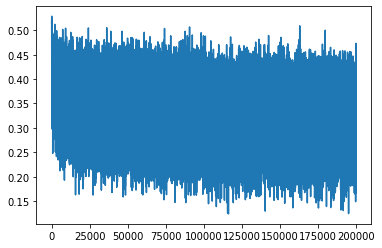

In [44]:
plt.plot(lossi);

`@torch.no_grad()` Basically tells the function beneath it that any tensors will not need to do gradient tracking. It improves efficiency

In [49]:
# Calibrate the batch norm at the end of the training
# Basically clamping the estimated batched values so that you can do inference 1 item at a time
# But no one wants this extra step. So these values are kept as a running mean and std during training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


If we were to check we would see that bnmean is roughly equal to bnmean_ running and the same for the stds

In [48]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0667834281921387
val 2.1049110889434814


### Log Loss

* Original
    * train 2.125
    * val   2.168
* Fix softmax confidently wrong
    * train 2.069
    * val   2.131
* Fix tanh layer too saturated init
    * train 2.036
    * val   2.103
* Add BatchNorm Layer *Doesn't make a difference in such a small network*
    * train 2.067
    * val   2.104

In [22]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amille.
khirmrex.
taty.
skanden.
jazonel.
den.
arci.
aqui.
ner.
kentzieiivia.
legy.
dham.
jorn.
quintis.
lilea.
jadii.
waythoniearynix.
kaeliigh.
boe.


### Putting everything together
Let's pytorchify the code

In [83]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (running estimate)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward Pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # Update Buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []    

In [86]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight += 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for  p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [87]:
# same optimization as before
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # Concat the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # Backward Pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain grpah
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track Stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # Obviusly take out after Debugging

      0/ 200000: 3.4828


### Network Initialization Analysis

In [95]:
# visualize histogram Tanh analysis
import pandas as pd
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histc(t)
        plt.plot(hx[:-1].detach, hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distributions');


layer 1 (      Tanh): mean -0.02, saturated: 0.75%


ValueError: too many values to unpack (expected 2)

<Figure size 1440x288 with 0 Axes>

In [92]:
torch.__version__

'1.8.0'